# Sentinel-1 Data Viewer
This notebook is used to review Sentinel-1 data over a specified region. The notebook includes several different data products including single data analysis and multi-date products. This data has been processed by Google Earth Engine using GRD scenes to create C-band backscatter intensity (VV and VH bands) at 10-meters spatial resolution. The data is consistently available from early 2017 for the globe. It is important to note that this data does NOT include radiometric terrain correction so there are issues using this data in areas with high elevation variation due to layover and shadowing.  
<br>
For more information about how to interpret radar data, see the following document:<br> "A Layman's Interpretation Guide to L-Band and C-Band Synthetic Aperture Radar Data" found <a href="https://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf" target="_blank"><b>HERE</b></a>.

In [1]:
# Ignore warnings 
import warnings
warnings.simplefilter('ignore')

from dea_tools.plotting import rgb, display_map

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import datacube
dc = datacube.Datacube() 

In [2]:
# Select and data platform and product
platform = ['Sentinel-1B']
platform = ['Sentinel-1A']
product = ['s1_rtc']

## <span id="define_extents">Define the Extents of the Analysis and View [&#9652;](#top)</span>

In [3]:
#@title Choose Example { run: "auto" }
example_name = "4.2.10 Savannah" #@param ["4.2.1 Dense tropical forest", "4.2.2 Deforestation & regrowth", "4.2.3 Flooded wetlands", "4.2.4 Mangroves", "4.2.5 Rubber", "4.2.6 Oil palm & Acacia", "4.2.7 Irrigated rice", "4.2.8 Agriculture", "4.2.9 Rangelands & pastures", "4.2.10 Savannah", "4.2.11 Arid terrain & rock outcrops", "4.2.12 Open water", "4.2.13 Signal attenuation"]
variable_name = "C-Band"
lat_long = ()
box_size_deg = ()
time_extents = ()

if example_name =="4.2.1 Dense tropical forest":
    lat_long = (0.90, -74.20)  # Changed this from 74.20 to -74.20
    box_size_deg = 0.20
    # Time Period
    # Consistent time series data is available from Jan-2017
    time_extents = ('2017-09-29', '2017-10-07') # example_date +/- 9 days
elif example_name=="4.2.2 Deforestation & regrowth":
    lat_long = (1.15, -74.50)  # Changed this from 74.50 to -74.50
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-09-29', '2017-10-07')
elif example_name=="4.2.3 Flooded wetlands":
    lat_long = (-1.90, -74.50)  # Changed this from 1.9 to -1.9 & 74.20 to -74.20
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-02-20', '2017-03-01') 
elif example_name=="4.2.4 Mangroves":
    lat_long = (-7.80, 39.30)  # Assuming the default as North East
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-08-29', '2017-09-07') 
elif example_name=="4.2.5 Rubber":
    lat_long = (11.15, 106.85)
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-06-10', '2017-06-19') 
elif example_name=="4.2.6 Oil palm & Acacia":
    lat_long = (0.15, 102.95)  
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-10-01', '2017-10-09') 
elif example_name=="4.2.7 Irrigated rice":
    lat_long = (10.60, 105.55)  
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-02-03', '2017-02-12') 
elif example_name=="4.2.8 Agriculture":
    lat_long = (46.95, 7.10)  
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-09-16', '2017-09-25') 
elif example_name=="4.2.9 Rangelands & pastures":
    lat_long = (-10.05, -51.85)  # Assuming as North East
    box_size_deg = 0.20
    # Time Period
    time_extents = ('2017-08-30', '2017-09-09') 
    #time_extents = ('2017-08-29', '2020-09-01') 
elif example_name=="4.2.10 Savannah":
    lat_long = (-1.45, 34.84)  #Assuming as North East
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-02-23', '2017-03-03') 
elif example_name=="4.2.11 Arid terrain & rock outcrops":
    lat_long = (2.6, 36.80)  # Assuming as North East did not show the exact location
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-10-09', '2017-10-18')
elif example_name=="4.2.12 Open water":
    lat_long = (10.00, 104.75)  
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-08-14', '2017-08-23')
elif example_name=="4.2.13 Signal attenuation":
    lat_long = (-2.42,-60.82) #Given S2.25º, W60.75º  
    box_size_deg = 0.30
      # Time Period
    time_extents = ('2017-05-03', '2017-05-29')
    
#test location
lat_long = (38.41560205774505, -76.0658344706419)  
box_size_deg = 0.30
time_extents = ('2020-01-01', '2020-01-31')
    
# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)





In [4]:
 display_map(longitude, latitude)

## Load the Data and View the Available Dates

In [5]:
measurements = dc.list_measurements()
measurements.loc[product]

name    dtype units  nodata  \
product measurement                                 
s1_rtc  vv              vv  float32     1     NaN   
        vh              vh  float32     1     NaN   
        angle        angle    uint8     1   255.0   
        area          area  float32     1     NaN   
        mask          mask    uint8     1     0.0   

                                                aliases  \
product measurement                                       
s1_rtc  vv                                         [VV]   
        vh                                         [VH]   
        angle            [ANGLE, local_incidence_angle]   
        area         [AREA, normalised_scattering_area]   
        mask                                     [MASK]   

                                                      flags_definition  \
product measurement                                                      
s1_rtc  vv                                                         NaN   
        vh                                                         NaN   
        angle                                                      NaN   
        area                                                       NaN   
        mask         {'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'val...   

                     add_offset  scale_factor  
product measurement                            
s1_rtc  vv                  NaN           NaN  
        vh                  NaN           NaN  
        angle               NaN           NaN  
        area                NaN           NaN  
        mask                NaN           NaN

In [6]:
# remove this load? #does not work if we remove this so have to keep this
sar_dataset = dc.load(product=product, measurements=['VV','VH'], 
                      time=time_extents, lat=latitude, lon=longitude, group_by='solar_day')

In [7]:
# Show acquisition indices and dates
pd.DataFrame(list(sar_dataset.time.values.astype('datetime64[D]')),columns=['Acquisition Date'])


,Acquisition Date
0,2020-01-02
1,2020-01-07
2,2020-01-14
3,2020-01-26
4,2020-01-31


In [8]:
# Choose a single year index (listed above)
acq_index = 0

## View Histogram Plots

In [9]:
#convert VV and VH to dB
sar_dataset['VVdB']=20 * np.log10(sar_dataset.VV)
sar_dataset['VHdB']=20 * np.log10(sar_dataset.VH)

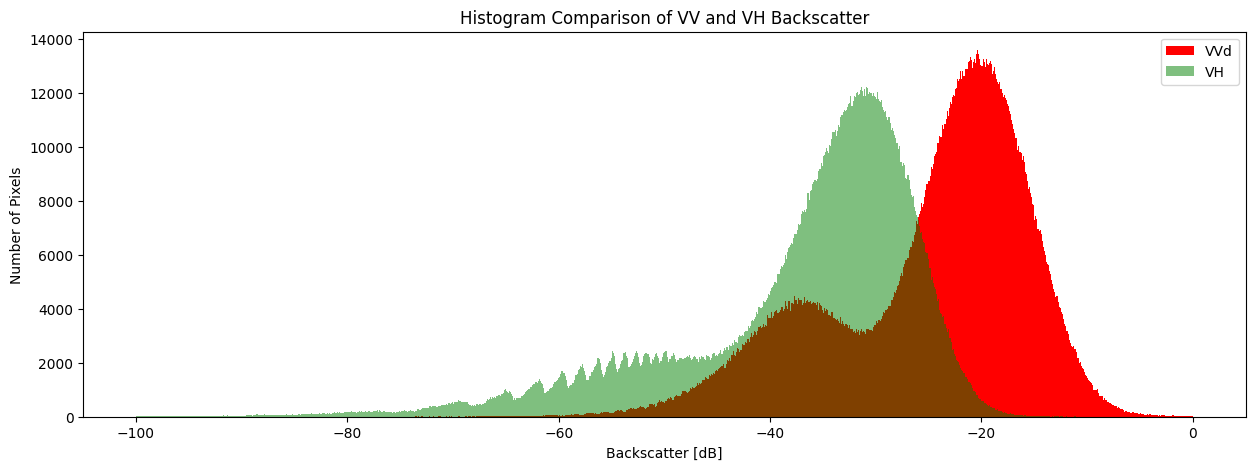

In [10]:
fig = plt.figure(figsize=(15, 5))
sar_dataset.isel(time=acq_index).VVdB.plot.hist(bins=1000, range=(-100,0), label="VVd", facecolor='red')
sar_dataset.isel(time=acq_index).VHdB.plot.hist(bins=1000, range=(-100,0), label="VH", alpha=0.5, facecolor='green')
plt.legend()
plt.xlabel("Backscatter [dB]")
plt.ylabel("Number of Pixels")
plt.title("Histogram Comparison of VV and VH Backscatter")
plt.show()

## Scale the backscatter amplitude for better image outputs
Backscatter amplitude for each band can be scaled to an 8-bit range of 0-255 to improve visual output and maximize contrast in VV and VH image products. This process is explained here. Gamma-nought backscatter amplitude (in dB units) is converted to raw (digital number) units using the conversion: DN (amplitude) = 10^(dB/20). Histograms are then used to view the range of dB values for the VV and VH bands. The range of expected values (across diverse land types) is then scaled to an 8-bit range using the formula: Scale = 256 / (range). Finally, an "offset" value is applied to allow the full range of values to be distributed across the 8-bit range. The final equation is: DN (amplitude, 8-bit) = ( DN(amplitude) - offset ) * scale. 

In [11]:
# Primary VV band range is -2dB to -25dB which is DN=0.79 to DN=0.056
# Primary VH band range is -8dB to -40dB which is DN=0.40 to DN=0.01
# Primary VV/VH range is 0.0 to 1.0. This data is scaled by 60 for improved color contrast

vv_convert = (10**(sar_dataset.VVdB/20)-0.056)*350
vh_convert = (10**(sar_dataset.VHdB/20)-0.01)*650
sar_dataset['vv_amp'] = vv_convert
sar_dataset['vh_amp'] = vh_convert
sar_dataset['vvvh_amp'] = (vv_convert / vh_convert) * 60

## VV, VH and RGB images

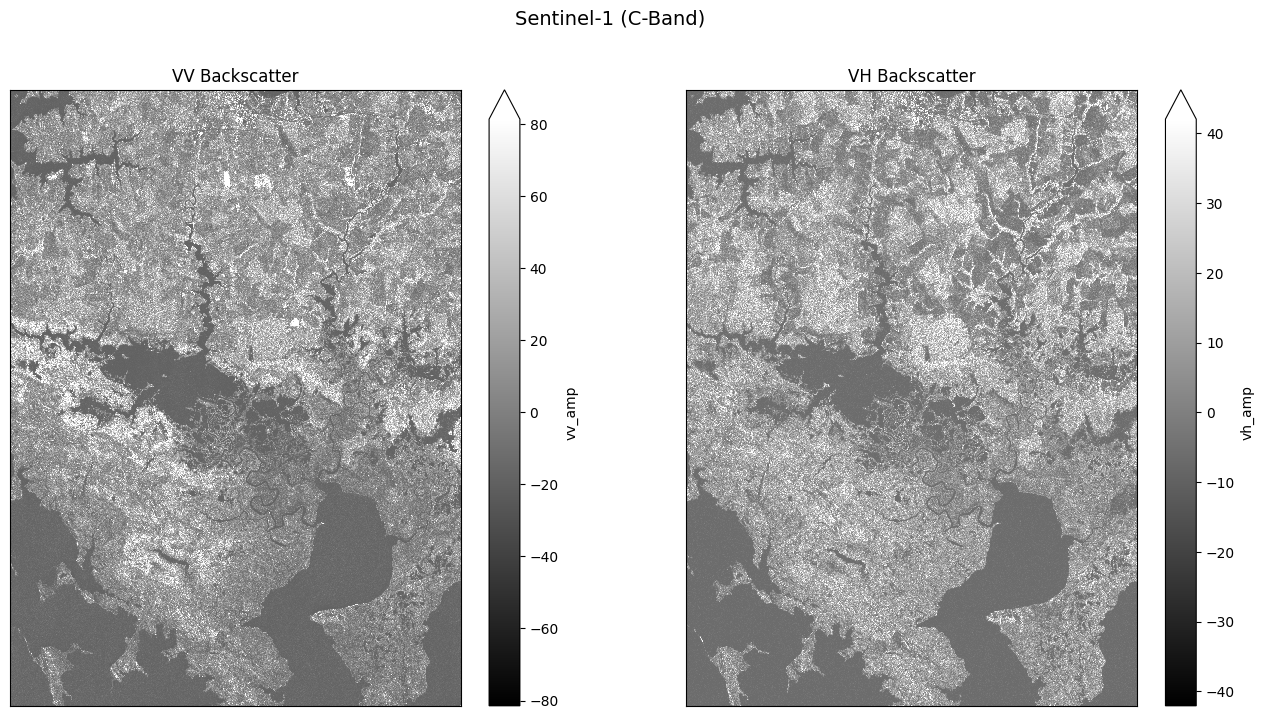

<Figure size 640x480 with 0 Axes>

In [12]:
# Plots of VV and VH Backscatter Intensity
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sar_dataset['vv_amp'][acq_index].plot(ax=ax[0],robust=True, cmap='gray')
sar_dataset['vh_amp'][acq_index].plot(ax=ax[1], robust=True,cmap='gray')
ax[0].set_title('VV Backscatter'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('VH Backscatter'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
fig.suptitle('Sentinel-1 (C-Band)',fontsize=14)
plt.show()
plt.tight_layout()

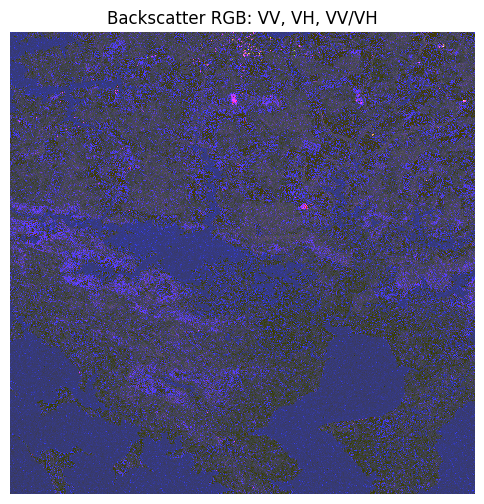

In [13]:
# RGB Plot of Backscatter Intensity (RGB= VV, VH, VV/VH)
# High backscatter (both bands) due to vegetation and foliage will appear as YELLOW (mix of red and green)
# New vegetation and urban areas are MAGENTA in color (due to high overall scattering and higher VV compared to VH)
# Low vegetation areas are BLUE (due to low overall scattering and higher VV compared to VH)
# Water is BLACK (low backscatter in both bands with similar VV and VH)

rgb(sar_dataset.isel(time=acq_index),bands=['vv_amp','vh_amp','vvvh_amp'])
plt.title('Backscatter RGB: VV, VH, VV/VH')
plt.axis('off')
plt.show()

# Want to do more?
Checkout S1 Viewer...